# INM707 Coursework Task 1
### Aaron Mir (Student Number: 160001207)


## Setting up MDP Environment

In [3]:
##--------------------Coding References---------------------## <img src="All_Tasks.png" alt="All_TasksOverview" width="700"/>  <img src="Task_1.png" alt="Task_1" width="700"/>
# Percentage of borrowed code: 5% - Modelled environment generaly like OpenAI Discrete Environments
# [1] OpenAI (2020) OpenAI Discrete Environments, 
# Available at: https://github.com/openai/gym/tree/38a1f630dc9815a567aaf299ae5844c8f8b9a6fa/gym/envs/toy_text (Accessed: 28th Feb 2021).

***
## Stronghold

The robot agent is preparing for an upcoming mission in which they are to infiltrate an enemy stronghold to gather intelligence on a potential coup d'état. The enemy land is in the form of an NxN grid with each grid containing one stronghold of size N x N/2 (starting on either side of the middle column (randomly decided)) and a wide river surrounding the entire enemy land. The entire land is very misty, therefore the robot may not step where it is supposed to. Each move has a transition probability associated with it (0.7 to move to the chosen state or 0.3 to move to one of the other sides) (stochasticity). The stronghold has as many entrances from the mainland as (1/4)N and contains (1/5)N dangerous enemy combatants (at random positions) within the stronghold that move around randomly per step (stochasticity).  The amount of shore that has traps on it is (1/4)N x rows of shore. The column immediately beside the stronghold is normal land to prevent entrance blocking. The goal of the agent is to infiltrate the stronghold and gather the intelligence without being killed by enemy combatants or booby traps as fast as possible.

This is a type of gridworld environment. The size (number of states) can be controlled by adjusting the grid dimensions.

The environment is defined as follows:

- The environment is a rectangular grid of states/cells. There are five different types of cells as indicated by the following cell labels: 

    - _ labels cells that are safe to step on i.e. normal land [0]

    - X labels the cells that are walls i.e. river or wall and if the agent enters a wall cell, there is a penalty of -1 [1]
    
    - A labels the cell the agent is on, starts on a random cell on the shore [2]
    
    - T labels booby-trap cells and if the agent enters a booby-trap cell there is a pentalty of -1000 and the episode ends [3]

    - E labels enemy cells and if the agent enters an enemy cell there is a pentalty of -1000 and the episode ends [4]

    - I labels the intelligence cell and when reached gives a reward of 2000 and the episode ends [5]

- There are four possible actions (Up, Down, Left, Right). 

- The transition function moves the agent in the expected direction with 0.7 probability, and there is a 0.3 probability of transitioning to one of the sides.

- There is a reward of -1 for each action taken by the agent, which is intended to encourage the agent to reach the goal as fast as possible. If the agent runs out of time, the episode ends. 

- Episodes end whenever the agent falls in a booby-trap, gets killed by an enemy, reaches the goal/intelligence or runs out of time. The end-of-episode is modelled by transitioning to a zero-reward terminal state (all actions lead to that state). 

State of the agent: Governed by the state number of the cell it is on.

States of the environment: Governed by the state number of the agent and the state number of moving enemies.

Number of states of the environment is given by the size of the grid and the size of the stronghold in which enemies can move. e.g. for a 10x10 grid with a stronghold size of 6x3 and 6 enemies, the number of states is 100 - 6x3-1 +  (6x3-1 (because of starting state)/6)  - 1 (because of the intelligence in the stronghold)

Rewards/Penalties: +2000 for getting intelligence, -1000 for getting hurt by a combatant or booby trap, -1 for moving into a wall or water, -1 per transition because of fuel constraints

***

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
from IPython.display import clear_output
np.set_printoptions(threshold=sys.maxsize, linewidth=sys.maxsize, precision = 2)

In [3]:
class Stronghold(): 
    def __init__(self, size, simplicity):
        self.size = size
        self.actions = {0: 'Up', 1: 'Down', 2: 'Left', 3: 'Right'}
        self.land = self.env_gen(simplicity)
        self.position_agent = None                                 # initial position of the agent will be decided by resetting the environment
        self.time_elapsed = 0                                      # run time
        self.simplicity = simplicity
        self.time_limit = self.size**2
        self.numActions, self.numStates = len(self.actions), size * size
        self.prob_of_tripping = [0.7, 0.1, 0.1, 0.1]               # 0.7 probability of going to where it chooses and 0.3 to go to differently
        self.P = {s:{a:[] for a in range(self.numActions)} for s in range(self.numStates)}      # dictionary mapping states and actions
        self.transitionProb = np.zeros((self.numActions, self.numStates + 1, self.numStates + 1))
        self.transitionReward = np.zeros((self.numStates + 1, self.numActions))
        self.fill_transitions_probability()
        self.dict_map_display={ 0:'_',          # normal land
                                1:'X',          # river/wall
                                2:'A',          # agent
                                3:'T',          # trap
                                4:'E',          # enemy
                                5:'I'}          # intelligence
                    
    def env_gen(self, simplicity):
        land = np.zeros((self.size, self.size))
        land[0,:] = 1                                               # establish the river
        land[:,0] = 1
        land[self.size-1,:] = 1
        land[:,self.size-1] = 1
        self.column_choice = np.random.choice((self.size//2-1, self.size//2+1)) # random choice whether stronghold starts from the left or right of the 'central' column
        land[1:self.size-1, self.column_choice] = 1
        if self.column_choice == self.size//2-1:                              # if stronghold is on left
            land[1:self.size-1, 0] = 1                                        # establish the walls of stronghold
            for col in land[1:self.size-1, self.column_choice+2:self.size-1].T:
                traps = []
                for i in range(int(np.round(1/simplicity*len(col)))):        # make as many traps as 1/simplicity of the length of each column in the shore
                    trap = np.random.choice(np.setdiff1d(range(len(col)), traps))
                    col[trap] = 3
                    traps.append(trap)
            for col in land[1:self.size-1, 1:self.column_choice].T:
                enemies = []
                for i in range(int(np.round(1/simplicity*len(col)))):        # populate enemies randomly inside the stronghold
                    enemy = np.random.choice(np.setdiff1d(range(len(col)), enemies))
                    col[enemy] = 4
                    enemies.append(enemy)
            intel_row = np.random.randint(1, len(land[1:self.size-1]))
            intel_col = np.random.randint(1, len(land[1:self.column_choice-1]))
            land[intel_row+1, intel_col] = 5
            self.position_intel = [intel_row+1, intel_col]            # randomly insert intelligence into stronghold
        else:                                                              # if stronghold is on right                          
            land[1:self.size-1, self.size-1] = 1                            # establish the walls of stronghold
            for col in land[1:self.size-1, 1:self.column_choice-1].T:
                traps = []
                for i in range(int(np.round(1/simplicity*len(col)))):        # make as many traps as 1/simplicity of the length of each column in the shore
                    trap = np.random.choice(np.setdiff1d(range(len(col)), traps))
                    col[trap] = 3
                    traps.append(trap)
            for col in land[1:self.size-1, self.column_choice+1:self.size-1].T:
                enemies = []
                for i in range(int(np.round(1/simplicity*len(col)))):        # populate enemies randomly inside the stronghold
                    enemy = np.random.choice(np.setdiff1d(range(len(col)), enemies))
                    col[enemy] = 4
                    enemies.append(enemy)
            intel_row = np.random.randint(1, len(land[1:self.size-1]))              
            intel_col = np.random.randint(1, len(land[self.column_choice+1:self.size-1]))
            land[intel_row+1, self.column_choice+intel_col] = 5
            self.position_intel = [intel_row+1, self.column_choice+intel_col]             # randomly insert intelligence into stronghold
        entrances = []
        for i in range(int(np.round((1/2)*len(land[2:self.size-2, self.column_choice])))):        # make as many entrances as 1/2 of the length of the front wall 
            entrance = np.random.choice(np.setdiff1d(range(len(land[2:self.size-2, self.column_choice])), entrances))
            land[2:self.size-2, self.column_choice][entrance] = 0
            entrances.append(entrance)
        return land

    def to_state(self, row, col):
            return row*self.size + col

    def inc(self, row, col, a):
        if a == 0:
            row = max(row-1,0)
        elif a == 1:
            row = min(row+1, self.size-1)       
        elif a == 2:
            col = max(col-1,0)
        elif a == 3:
            col = min(col+1,self.size-1)
        return (row, col)
    
    def fill_transitions_probability(self):
        for row in range(self.size):
            for col in range(self.size):
                s = self.to_state(row, col)
                for a in range(4):
                    trans_prob = self.P[s][a]
                    number = self.land[row, col]
                    if number == 3: # trap
                        trans_prob.append((1.0, s, 0, True))
                        self.transitionProb[a, s, self.numStates] = 1.0
                        self.transitionReward[s, a] = -1000
                    elif number == 4: # enemy
                        trans_prob.append((1.0, s, 0, True))
                        self.transitionProb[a, s, self.numStates] = 1.0
                        self.transitionReward[s, a] = -1000
                    elif number == 5: # intelligence
                        trans_prob.append((1.0, s, 0, True))
                        self.transitionProb[a, s, self.numStates] = 1.0
                        self.transitionReward[s, a] = 2000
                    else:
                        for b, p in zip([a, (a+1)%4, (a+2)%4, (a+3)%4], self.prob_of_tripping):
                            newrow, newcol = self.inc(row, col, b)
                            newstate = self.to_state(newrow, newcol)
                            newnumber = self.land[newrow][newcol]
                            done = False
                            if newnumber == 3:                  # if enters trap
                                rew = -1000
                            elif newnumber == 4:                # if enemy kills
                                rew = -1000
                            elif newnumber == 5:                # if intelligence is caught
                                rew = 2000
                            else:
                                rew = -1                        # penalty for time-step               
                            trans_prob.append((p, newstate, rew, done))
                            self.transitionProb[a, s, newstate] += p
                            self.transitionReward[s, a] = -1 
    
    def getSuccessors(self, s, a): 
        # Take a state and an action as input, and return a list of pairs, where each pair (s', p) is a successor state s' with non-zero probability and p is the probability of transitioning to p.
        idx = [0, 3, 1, 2] # up left right down rearrange to up down left right [0, 3, 1, 2]    left right up down [1, 2, 0, 3]
        next_states = np.nonzero(self.transitionProb[a, s, :]) # np.nonzero(self.transitionProb[a, s, :])
        probs = self.transitionProb[a, s, next_states]
        if np.size(next_states[0]) == 1:
            return next_states[0]
        else:        
            return [(s,p) for s,p in zip(next_states[0][idx], probs[0][idx])]  

    def gettransitionProb(self, s, a, ns):
        # Take a state, an action, a next state as input, and return the probability of the transition 
        return self.transitionProb[a, s, ns]

    def getReward(self, s, a):
        # Take a state and an action as input, and return the reward of that.
        return self.transitionReward[s, a]

    def getStateSpace(self):
        return self.transitionProb.shape[1]
    
    def getActionSpace(self):
        return self.transitionProb.shape[0]

    def normal_shore(self, n_cells):
        if self.column_choice == self.size//2-1:
            empty_cells_coord = np.where(self.land[1:self.size-1, self.column_choice+1:self.size-1] == 0)
            selected_indices = np.random.choice(np.arange(len(empty_cells_coord[0])), n_cells)
            selected_coordinates = empty_cells_coord[0][selected_indices]+1, empty_cells_coord[1][selected_indices]+len(self.land[1][:self.column_choice+1])
        if self.column_choice == self.size//2+1:
            empty_cells_coord = np.where(self.land[1:self.size-1, 1:self.column_choice] == 0)
            selected_indices = np.random.choice(np.arange(len(empty_cells_coord[0])), n_cells)
            selected_coordinates = empty_cells_coord[0][selected_indices]+1, empty_cells_coord[1][selected_indices]+1
        if n_cells == 1:
            return np.asarray(selected_coordinates).reshape(2,)
        return selected_coordinates

    def step(self, action): # action is 0, 1, 2, 3 for up, down, left, right
        for i, j in zip(*np.where(self.land == 4)):     # enemies move randomly - they do not move if their choice is a wall, the intelligence, another enemy or the stronghold entrance column
            move = np.random.choice(('up', 'down', 'left', 'right'))
            if move == 'up' and self.land[i-1, j] != 1 and self.land[i-1, j] != 4 \
                and self.land[i-1, j] != 5:
                self.land[i, j] = 0
                self.land[i-1, j] = 4
            if move == 'down' and self.land[i+1, j] != 1 and self.land[i+1, j] != 4 \
                and self.land[i+1, j] != 5:
                self.land[i, j] = 0
                self.land[i+1][j] = 4
            if move == 'left' and self.land[i, j-1] != 1 and self.land[i, j-1] != 4 \
                and self.land[i, j-1] != 5 and j-1 != self.column_choice:
                self.land[i, j] = 0
                self.land[i, j-1] = 4
            if move == 'right' and self.land[i, j+1] != 1 and self.land[i, j+1] != 4 \
                and self.land[i, j+1] != 5 and j+1 != self.column_choice:
                self.land[i, j] = 0
                self.land[i, j+1] = 4

        current_position = np.array((self.position_agent[0], self.position_agent[1])) # saving the current position and state in case agent hits a wall
        current_state = self.agent_state
        options = self.getSuccessors(current_state, action)                           # chosen action gets 0.7 prob 
        if np.size(options) != 1:
            probs = [i[1] for i in options]                                               #  list of probabilities
            choice = np.random.choice((0, 1, 2, 3), p=probs)                              #  make a probability choice
            state_choice = options[choice][0]
            ind = np.where(self.P[self.agent_state][action][:][:] == state_choice)[0][0]
            prob, new_state, reward, done = self.P[self.agent_state][action][ind]    # new prob, state, reward, done for the choice                 

            self.agent_state = new_state                                                # agent state and cell index position gets updated
            if choice == 0:                                                             # up                                   
                self.position_agent[0] -= 1
            if choice == 1:                                                             # down
                self.position_agent[0] += 1
            if choice == 2:                                                             # left
                self.position_agent[1] -= 1 
            if choice == 3:                                                             # right
                self.position_agent[1] += 1
        
            if self.land[self.position_agent[0], self.position_agent[1]] == 1:          # condition where they walk into a wall
                self.position_agent = current_position                                  # state and position of agent = old state and position
                new_state = current_state
                self.agent_state = new_state
                reward -= 1                                                             # additional penalty for bumping into wall
        else:
            prob, new_state, reward, done = self.P[self.agent_state][action][0]
            if self.time_elapsed == self.time_limit:                                    # time-limit termination condition
                done = True
                print ('Time ran out')
            else:
                self.time_elapsed += 1                                                  # update time
                    
        return (int(new_state), reward, done, {"prob" : prob})                      # return state, reward, done, info

    def reset(self):
        self.time_elapsed = 0                                              # put time_elapsed to 0
        self.position_agent = np.asarray(self.normal_shore(1))             # position of the agent is a random cell on the shore
        self.agent_state = self.to_state(self.position_agent[0], self.position_agent[1])
        self.starting_pos = self.position_agent               
        return self.agent_state                                             # return current state as observation

    def render(self):                                                       # display
        envir_with_agent = self.land.copy()
        envir_with_agent[self.position_agent[0], self.position_agent[1]] = 2
        
        fig, ax = plt.subplots(figsize=(5, 5))
        im = ax.imshow(envir_with_agent) 

        ax.set_xticks(np.arange(len(envir_with_agent)))
        ax.set_yticks(np.arange(len(envir_with_agent)))
        
        for i in range(len(envir_with_agent)):                              # loop over data dimensions and create text annotations
            for j in range(len(envir_with_agent)):
                if envir_with_agent[i, j] == 0:
                    caption = ""
                elif envir_with_agent[i, j] == 1:
                    caption = "X"
                elif envir_with_agent[i, j] == 2:
                    caption = "A"
                elif envir_with_agent[i, j] == 3:
                    caption = "T"
                elif envir_with_agent[i, j] == 4:
                    caption = "E"
                elif envir_with_agent[i, j] == 5:
                    caption = "I"
                else:
                    caption = ""    
                text = ax.text(j, i, caption, ha="center", va="center", color="r", fontsize='xx-large')

        ax.set_title("Stronghold", fontsize=15) # 35 for 10x10 
        fig.tight_layout()
        plt.axis('off')
        plt.show()

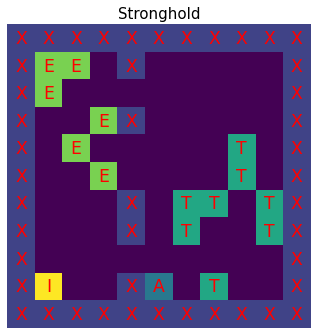

In [4]:
env_size = 11
simplicity = 5
stronghold = Stronghold(env_size, simplicity)
stronghold.reset()
stronghold.render()

In [6]:
def random_policy(): 
    return np.random.randint(0, stronghold.getActionSpace() - 1)

def evaluate_policy(env, policy, episodes = 1000, view = True, print_ep_reward=False):
    # renders the environment and agent at each step if view is True
    # this takes up time so if you want it to be quicker just set view to False
    total_evaluation_reward = 0
    for i in range(episodes):                   # iterating over a certain number of episodes 
        env.reset()
        episode_reward = 0
        done = False
        state, reward, done, info = env.step(policy)
        episode_reward += reward
        total_evaluation_reward += reward
        while not done:
            state, reward, done, info = env.step(policy)        # perform random step
            episode_reward += reward
            total_evaluation_reward += reward
            if view == True:
                print("state", state)
                env.render()
                time.sleep(0.5)
                clear_output(wait=True)
        if print_ep_reward == True:
            print("Total reward for trial = ", episode_reward)
    return total_evaluation_reward / episodes                   # return average reward over all episodes

In [19]:
env_size = 11
simplicity = 4
stronghold = Stronghold(env_size, simplicity)            
print("Average reward:", evaluate_policy(stronghold, random_policy(), episodes=10, view=False, print_ep_reward=True)) # <- set view to True if you want the environment to show during evaluation and print to see the reward per episode

Total reward for trial =  927
Total reward for trial =  -1001
Total reward for trial =  -1000
Total reward for trial =  858
Total reward for trial =  970
Total reward for trial =  954
Total reward for trial =  -1019
Total reward for trial =  -1085
Total reward for trial =  -1004
Total reward for trial =  -1021
Average reward: -242.1


In [21]:
env_size = 11
simplicity = 6
stronghold = Stronghold(env_size, simplicity)            
print("Average reward:", evaluate_policy(stronghold, random_policy(), episodes=1000, view=False, print_ep_reward=False)) 

Average reward: -772.561


In [31]:
env_size = 21
simplicity = 6
stronghold = Stronghold(env_size, simplicity)            
print("Average reward:", evaluate_policy(stronghold, random_policy(), episodes=10000, view=False, print_ep_reward=False)) 

Average reward: -1043.9177
